# CNN on NY

## IMPORT

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix
from sklearn.metrics import mean_absolute_error

In [5]:
# Import Library.
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

In [6]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!nvidia-smi

Tue May 10 12:37:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    29W / 350W |    938MiB / 12288MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dempster shafer layers import

In [9]:
sys.path.append('../E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## UTILS

### UTILS PATHS

In [10]:
checkpointPath = Path('Outputs/CNN/CHECKPOINTS/')
graphPath = Path('Outputs/CNN/GRAPHS/')
pathSavedModel = Path('Outputs/CNN/MODELS-PB/')
plotpath = Path('Outputs/CNN/PLTS/')


databasePath = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/newDB.csv')
databasePathIMAGES = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/SEGMENTATION/')

In [11]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)

### RANDOM NUMBER

In [12]:
random_seed = 42

### GLOBAL VARIABLES

In [13]:
IMAGE_SIZE = [224,224]
CLASS_NAMES = ['MILD', 'SEVERE']

### FUNCTIONS

In [14]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
        plt.show()

In [15]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    # tf.keras.metrics.Accuracy(name='accuracy'),
    # tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="True_Positives"),
    tf.keras.metrics.TrueNegatives(name="True_Negatives"),
    tf.keras.metrics.FalsePositives(name="False_Positives"),
    tf.keras.metrics.FalseNegatives(name="False_Negatives"),
]

### LOAD PNG instead of DICOM function

In [16]:
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        # p = Path(p).stem + '.png'
        p = Path(p)
        # print(p)
        fullPath = Path(str(basePath) + str(p))
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array    
    return imgs

## SETUP Datasets

### Import Database DICOM

In [17]:
# read in all our data
COVID19 = pd.read_csv(databasePath)
COVID19 = COVID19.drop(['covid19_statuses'], axis='columns')

COVID19 = pd.DataFrame(COVID19[['to_patient_id','is_icu','FilePaths']])
print(COVID19.shape)

(1279, 3)


In [18]:
COVID19 = pd.read_csv(databasePath)
COVID19 = COVID19.drop(['covid19_statuses'], axis='columns')

COVID19 = pd.DataFrame(COVID19[['to_patient_id','is_icu','FilePaths']])
print(COVID19.shape)

(1279, 3)


In [19]:
COVID19.head()

,to_patient_id,is_icu,FilePaths
0,A917122,MILD,/MILD/0_A917122.png
1,A387558,SEVERE,/SEVERE/1_A387558.png
2,A968238,SEVERE,/SEVERE/2_A968238.png
3,A642300,SEVERE,/SEVERE/3_A642300.png
4,A205701,MILD,/MILD/4_A205701.png


In [20]:
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x



takename = copy.deepcopy(COVID19['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

COVID19['MILD'] = one_h_enc[:,0]
COVID19['SEVERE'] = one_h_enc[:,1]

In [21]:
COVID19.head()

,to_patient_id,is_icu,FilePaths,MILD,SEVERE
0,A917122,MILD,/MILD/0_A917122.png,1.0,0.0
1,A387558,SEVERE,/SEVERE/1_A387558.png,0.0,1.0
2,A968238,SEVERE,/SEVERE/2_A968238.png,0.0,1.0
3,A642300,SEVERE,/SEVERE/3_A642300.png,0.0,1.0
4,A205701,MILD,/MILD/4_A205701.png,1.0,0.0


In [22]:
#CHECK PROGNOSIS
# X_full = pd.DataFrame(COVID19_dataHK[['ImageFile']])
X_full = pd.DataFrame(COVID19.drop(['is_icu','MILD','SEVERE'], axis='columns'))
#without images:
Y_full = pd.DataFrame(COVID19[['MILD','SEVERE']])

In [23]:
X_full.head()

,to_patient_id,FilePaths
0,A917122,/MILD/0_A917122.png
1,A387558,/SEVERE/1_A387558.png
2,A968238,/SEVERE/2_A968238.png
3,A642300,/SEVERE/3_A642300.png
4,A205701,/MILD/4_A205701.png


In [24]:
Y_full.head()

,MILD,SEVERE
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


### wheights for classes

In [25]:
mildNumber = Y_full.sum()[0]
print(mildNumber)
severeNumber = Y_full.sum()[1]
print(severeNumber)
total = Y_full.sum().sum()

1022.0
257.0


In [26]:
weight_for_mild = (1 / (mildNumber)) * (total / 2.0)
weight_for_severe = (2 / (severeNumber)) * (total / 2.0)

class_weights = {0: weight_for_mild, 1: weight_for_severe}

In [27]:
print('Weight for class MILD: {:.2f}'.format(weight_for_mild))
print('Weight for class SEVERE: {:.2f}'.format(weight_for_severe))

Weight for class MILD: 0.63
Weight for class SEVERE: 4.98


### Division in train val

In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True, random_state=random_seed)

### IMPORT PNG Images

In [29]:
# X_trainIMG = loadPNGtoArray(X_train['FilePaths'],basePath=databasePathIMAGES)
# X_valIMG = loadPNGtoArray(X_val['FilePaths'],basePath=databasePathIMAGES)

In [55]:
imagePaths= Path('../CHEST-RAY-ONLY-LABELED-ICU-ALL-ORDERED/SEGMENTATION/')

trainset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(224,224),label_mode='categorical',shuffle=True,seed=42,validation_split=0.2,subset='training')
valset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(224,224),label_mode='categorical',shuffle=True,seed=42,validation_split=0.2,subset='validation')

Found 4168 files belonging to 2 classes.
Using 3335 files for training.
Found 4168 files belonging to 2 classes.
Using 833 files for validation.


In [56]:
print(trainset)
print(valset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [57]:
# print(X_trainIMG.shape)
# print(X_valIMG.shape)

In [58]:
# plt.figure()
# plt.imshow(X_valIMG[2])

## MODELS DEFINITION AND USE

### CNN Multi layer fusion without DS

In [59]:
def ResFBlock(x,filt,kernel,stride):
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    # x = Dropout(0.6)(x)
    return x

In [60]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionConc(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.7)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.7)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    
    block1 = Flatten()(block1)
    block2 = Flatten()(block2)
    block3 = Flatten()(block3)
    block4 = Flatten()(block4)
    block5 = Flatten()(block5)
    
    massFusion = Concatenate()([block1,block2,block3,block4,block5])

    outputs = Dense(32, activation='relu')(massFusion)
    outputs = Dense(8, activation='relu')(outputs)


    outputs = Dense(2, activation=lastActivation)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [61]:
model = DSfusionConc((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [62]:
# model.summary()

In [63]:
# plot_model(model, to_file=plotpath / Path('Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [64]:
# train_data_generator = idg.flow(X_trainIMG, y = Y_train[['MILD','SEVERE']],
# 					       seed=42, shuffle = True)
# valid_data_generator = idg.flow(X_valIMG, y = Y_val[['MILD','SEVERE']],
# 					       seed=42, shuffle = True)
						   

In [65]:
# METRS = [
#     'BinaryAccuracy',
#     'Precision',
#     'Recall',
# ]

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        optimizer='adam',
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
        loss="binary_crossentropy",
        metrics=METRICS,
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('model_CONCAT_callback_CONCAT'), 
						monitor='val_binary_accuracy', verbose=0, 
						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# history = model.fit(
#         x = X_trainIMG,
#         y = Y_train,
#         epochs = 300,
#         validation_data = [X_valIMG,Y_val],
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
#         batch_size= 32,
#         class_weight= class_weights
# )
history = model.fit(
        x = trainset,
        epochs = 300,
        validation_data = valset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size= 32,
        # class_weight= class_weights
)

# history = model.fit(
#         x = train_data_generator,
#         epochs = 300,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
105/105 [==============================] - 21s 176ms/step - loss: 1.4865 - binary_accuracy: 0.6265 - precision: 0.6237 - recall: 0.6376 - True_Positives: 3368.0000 - True_Negatives: 3250.0000 - False_Positives: 2032.0000 - False_Negatives: 1914.0000 - val_loss: 1.2737 - val_binary_accuracy: 0.6351 - val_precision: 0.6351 - val_recall: 0.6351 - val_True_Positives: 529.0000 - val_True_Negatives: 529.0000 - val_False_Positives: 304.0000 - val_False_Negatives: 304.0000
Epoch 2/300
105/105 [==============================] - 16s 138ms/step - loss: 1.1409 - binary_accuracy: 0.6303 - precision: 0.6303 - recall: 0.6303 - True_Positives: 2102.0000 - True_Negatives: 2102.0000 - False_Positives: 1233.0000 - False_Negatives: 1233.0000 - val_loss: 1.0289 - val_binary_accuracy: 0.6351 - val_precision: 0.6351 - val_recall: 0.6351 - val_True_Positives: 529.0000 - val_True_Negatives: 529.0000 - val_False_Positives: 304.0000 - val_False_Negatives: 304.0000
Epoch 3/300
105/105 [===============

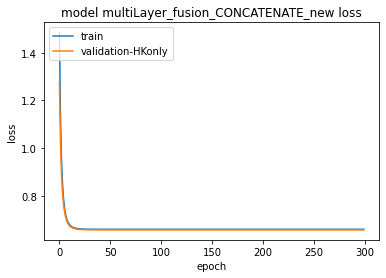

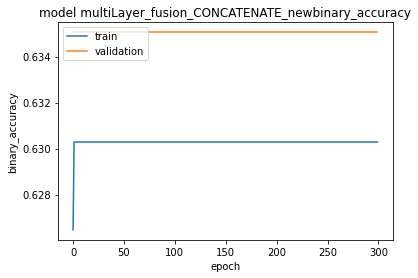

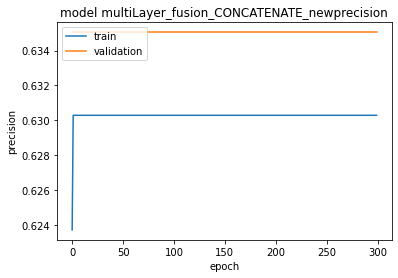

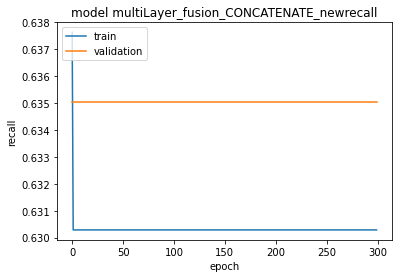

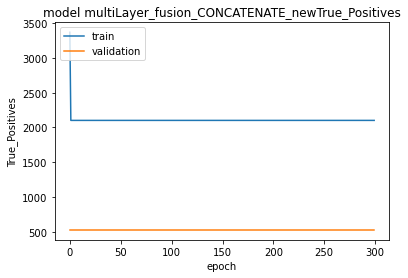

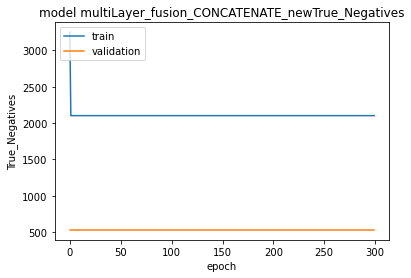

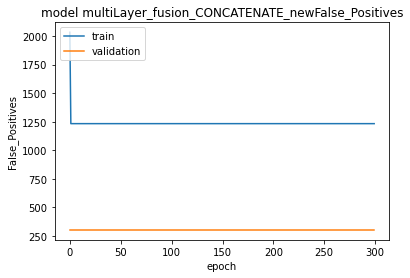

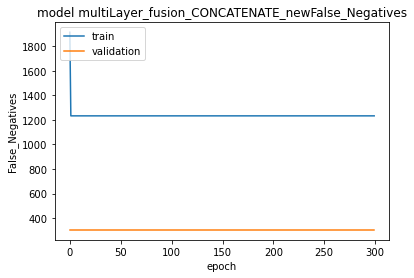

INFO:tensorflow:Assets written to: Outputs\CNN\MODELS-PB\multiLayer_fusion_CONCATENATE_new\assets


In [66]:
        
printAndSaveGraphs(graphPath,'multiLayer_fusion_CONCATENATE_new',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)
# or save to csv: 
hist_csv_file = graphPath / 'history_multiLayer_fusion_CONCATENATE_new.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / 'multiLayer_fusion_CONCATENATE_new')

In [67]:
bestPt = checkpointPath / Path('model_CONCAT_callback_CONCAT')
model = tf.keras.models.load_model(bestPt)

In [73]:


# evaluation = model.evaluate(X_valIMG, Y_val)

# evaluation = model.evaluate(valset)

# preds = model.predict(X_valIMG)

preds = model.predict(valset)

print(preds)

# ypreds = np.argmax(preds, axis=1)
# print(ypreds)

# yground = np.argmax(Y_val.to_numpy(), axis=1)
# print(yground)

ypreds = np.array([])
yground = np.array([])

for x,y in valset:
    ypreds = np.concatenate([ypreds, np.argmax(model.predict(x), axis=-1)])
    yground = np.concatenate([yground, np.argmax(y.numpy(), axis=-1)])

print(ypreds)
print(yground)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

evaluation = dict(zip(model.metrics_names,evaluation))
# print(evaluation)


with open('Outputs/CNN/CNN_CONCAT_NY.txt', 'w') as f:
    f.write('CNN concat on NY KERAS METRICS'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN concat on NY'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> \n'+ str(cmatrix) + '\n\n')

[[0.48047218 0.5178556 ]
 [0.48047218 0.5178556 ]
 [0.48047218 0.5178556 ]
 ...
 [0.48047218 0.5178556 ]
 [0.48047218 0.5178556 ]
 [0.48047218 0.5178556 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

### CNN Multi layer fusion with DS

In [74]:
prototypes = 40
# prototypes = 1
num_class = 2

In [75]:
def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

In [76]:
# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     lout = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)


#     return lout
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout




In [77]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = DSmassCalcLayer(block1)
    block2 = Flatten()(block2)
    block2 = DSmassCalcLayer(block2)
    block3 = Flatten()(block3)
    block3 = DSmassCalcLayer(block3)
    block4 = Flatten()(block4)
    block4 = DSmassCalcLayer(block4)
    block5 = Flatten()(block5)
    block5 = DSmassCalcLayer(block5)
    
    # massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # massFusion = Add()([block1,block2,block3,block4,block5])
    # massFusion = layers.Average()([block1,block2,block3,block4,block5])
    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    #MASS ON CONCATENATION
    # print(massFusion.shape)
    # pt = math.floor(massFusion.shape[1]/50)

    # ED = ds_layer.DS1(pt,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(pt)(ED)
    # mass_prototypes = ds_layer.DS2(pt, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(pt, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(pt, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)


    # DA DS2 IN DS3
    newNprot = (num_class+1)*5
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
    

    # # DA DS1 IN DS3
    # # newNprot = (num_class+1)*5
    # newNprot = 40
    # ED = ds_layer.DS1(newNprot,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(newNprot)(ED)
    # mass_prototypes = ds_layer.DS2(newNprot, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)



    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)
    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)

    # mass_Dempster = ds_layer.DS3_Dempster(5*prototypes, num_class)(massFusion)
    # # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(massFusion)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM(0.9,num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [78]:
model = DSfusionML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [79]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 112, 112, 16  1216        ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
plot_model(model, to_file=plotpath / Path('DS_Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [81]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False
)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        # loss="hinge",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('model_DS_callback_DS_not_gen_2'), 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# history = model.fit(
#         x = X_trainIMG,
#         y = Y_train,
#         epochs = 500,
#         validation_data = [X_valIMG,Y_val],
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
#         batch_size=32,
#         class_weight= class_weights
# )
history = model.fit(
        x = trainset,
        epochs = 300,
        validation_data = valset,
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size= 32,
        # class_weight= class_weights
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 500,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
105/105 [==============================] - ETA: 0s - loss: 1.0953 - binary_accuracy: 0.5981 - precision: 0.5981 - recall: 0.5981 - True_Positives: 2493.0000 - True_Negatives: 2493.0000 - False_Positives: 1675.0000 - False_Negatives: 1675.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.63505, saving model to Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_not_gen_2
INFO:tensorflow:Assets written to: Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_not_gen_2\assets
105/105 [==============================] - 76s 418ms/step - loss: 1.0953 - binary_accuracy: 0.5981 - precision: 0.5981 - recall: 0.5981 - True_Positives: 2493.0000 - True_Negatives: 2493.0000 - False_Positives: 1675.0000 - False_Negatives: 1675.0000 - val_loss: 1.5539 - val_binary_accuracy: 0.6351 - val_precision: 0.6351 - val_recall: 0.6351 - val_True_Positives: 529.0000 - val_True_Negatives: 529.0000 - val_False_Positives: 304.0000 - val_False_Negatives: 304.0000
Epoch 2/300
105/105 [==========================

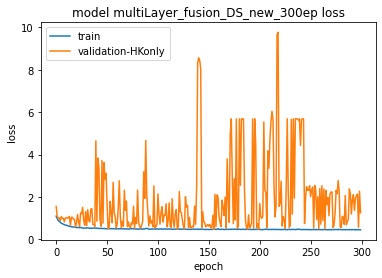

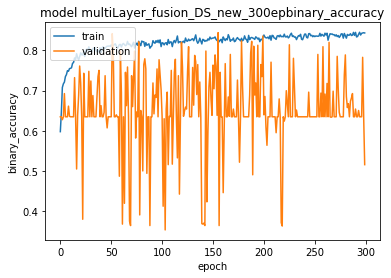

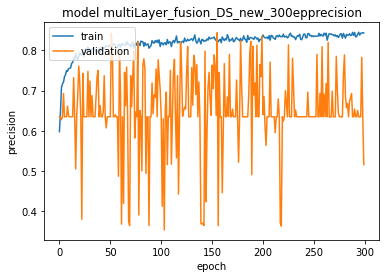

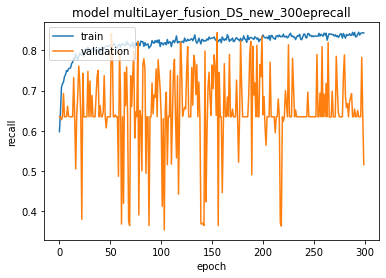

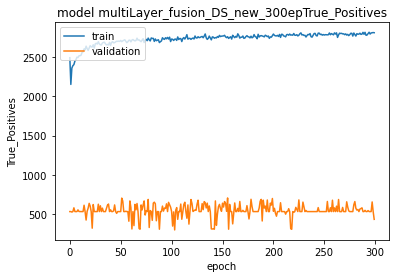

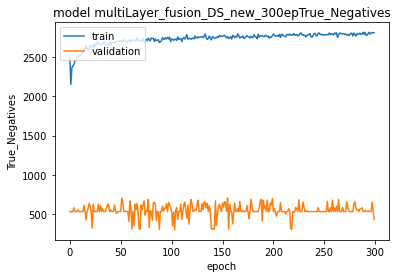

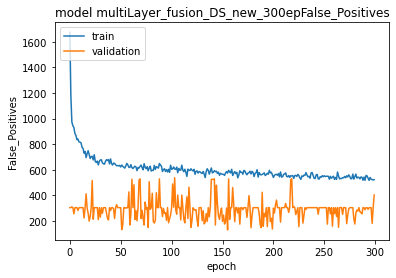

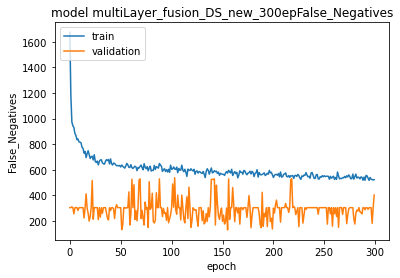

INFO:tensorflow:Assets written to: Outputs\CNN\MODELS-PB\multiLayer_fusion_DS_new_300ep\assets


In [82]:
printAndSaveGraphs(graphPath,'multiLayer_fusion_DS_new_300ep',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('history_multiLayer_fusion_DS_new_300ep.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('multiLayer_fusion_DS_new_300ep'))

In [83]:
bestPt = checkpointPath / Path('model_DS_callback_DS_not_gen_2')
model = tf.keras.models.load_model(bestPt)

In [84]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error



# evaluation = model.evaluate(X_valIMG, Y_val)

evaluation = model.evaluate(valset)

# preds = model.predict(X_valIMG)

# ypreds = np.argmax(preds, axis=1)
# print(ypreds)

# yground = np.argmax(Y_val.to_numpy(), axis=1)
# print(yground)

ypreds = np.array([])
yground = np.array([])

for x,y in valset:
    ypreds = np.concatenate([ypreds, np.argmax(model.predict(x), axis=-1)])
    yground = np.concatenate([yground, np.argmax(y.numpy(), axis=-1)])

# print(ypreds)
# print(yground)


score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)


evaluation = dict(zip(model.metrics_names,evaluation))

with open('Outputs/CNN/CNN_DS_NY.txt', 'w') as f:
    f.write('CNN with DS on NY KERAS METRICS:'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN with DS on NY:'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

27/27 [==============================] - 6s 93ms/step - loss: 0.4740 - binary_accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - True_Positives: 703.0000 - True_Negatives: 703.0000 - False_Positives: 130.0000 - False_Negatives: 130.0000
accuracy:  0.843937575030012
log_loss:  5.390281991756067
precision:  0.8568872987477638
recall:  0.9054820415879017
[[224  80]
 [ 50 479]]


In [85]:
tn,fp,fn,tp = cmatrix.ravel()

print('true negative: '+str(tn))
print('false positive: '+str(fp))
print('false negative: '+str(fn))
print('true positive: '+str(tp))

true negative: 224
false positive: 80
false negative: 50
true positive: 479
